In [1]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Define the ARIMA forecasting function
def arima_forecast(data, order=(5, 1, 0), steps=31):
    """
    Fit an ARIMA model and forecast future values.

    Parameters:
        data (array-like): The time series data for training the ARIMA model.
        order (tuple): The (p, d, q) order of the ARIMA model.
        steps (int): The number of steps to forecast.

    Returns:
        forecast (array): Forecasted values.
    """
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    return forecast

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Evaluation Metrics (ARIMA):
Mean Absolute Error (MAE): 0.2003
Mean Squared Error (MSE): 0.0795
Root Mean Squared Error (RMSE): 0.2819
Mean Absolute Percentage Error (MAPE): 1.90%


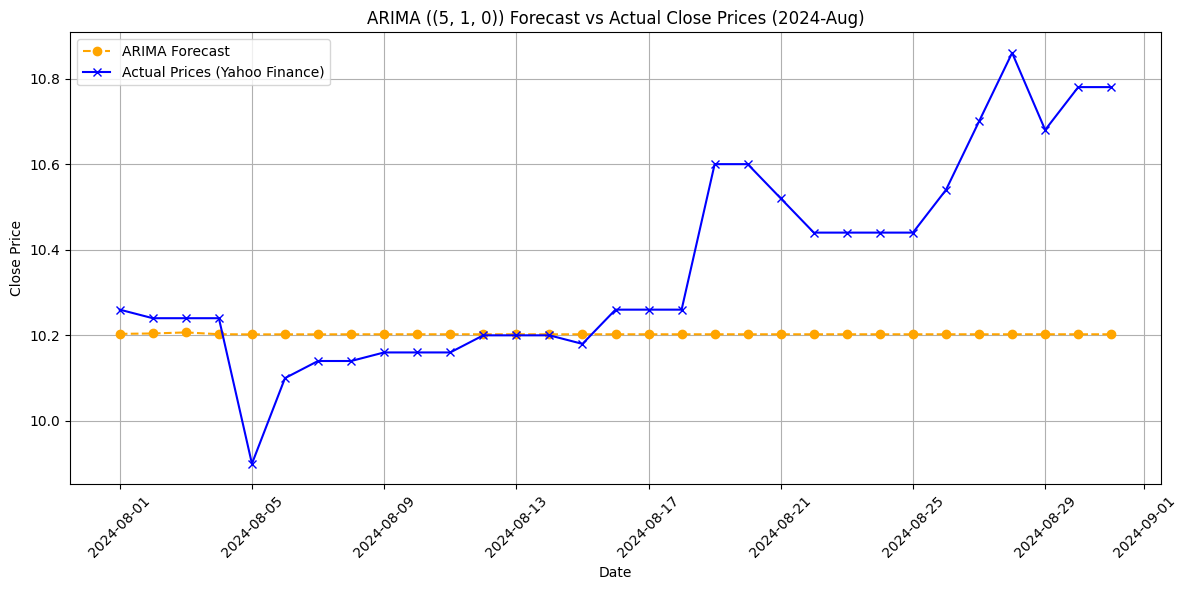

In [3]:
# Step 1: Fetch historical data for ARIMA training
ticker = "1155.KL"
data = yf.download(ticker, start="2023-01-01", end="2024-08-01")  # Historical data for ARIMA
actual_data = yf.download(ticker, start="2024-08-01", end="2024-09-01")  # Actual data for evaluation

# Extract the Close prices for ARIMA
close_prices = data['Close'].dropna().values  # Ensure no NaN values
actual_data['Close'] = actual_data['Close'].fillna(method='ffill')  # Forward-fill missing values

# Step 2: Apply ARIMA to forecast
forecast_horizon = 31  # Forecast for August 2024
arima_order = (5, 1, 0)  # Example ARIMA order (p, d, q)
forecast = arima_forecast(close_prices, order=arima_order, steps=forecast_horizon)

# Step 3: Align actual data with forecast dates
forecast_dates = pd.date_range(start="2024-08-01", periods=forecast_horizon)  # Generate forecast dates
actual_data = actual_data.reindex(forecast_dates, method='ffill')  # Reindex actual data to match forecast dates
actual_prices = actual_data['Close'].values  # Extract actual prices as a numpy array
actual_dates = actual_data.index  # Extract aligned dates

# Step 4: Handle any remaining length mismatches
if len(actual_prices) != len(forecast):
    print(f"Warning: Length mismatch after reindexing! Forecast ({len(forecast)}) vs Actual ({len(actual_prices)})")
    min_length = min(len(actual_prices), len(forecast))
    actual_prices = actual_prices[:min_length]  # Truncate to match the shorter length
    forecast = forecast[:min_length]  # Truncate to match the shorter length
    forecast_dates = forecast_dates[:min_length]  # Adjust forecast dates

# Step 5: Calculate evaluation metrics
mae = mean_absolute_error(actual_prices, forecast)
mse = mean_squared_error(actual_prices, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_prices - forecast) / (actual_prices + 1e-8))) * 100  # Avoid divide-by-zero

# Print evaluation metrics
print("Evaluation Metrics (ARIMA):")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Step 6: Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, forecast, label="ARIMA Forecast", marker="o", linestyle="--", color="orange")
plt.plot(actual_dates, actual_prices, label="Actual Prices (Yahoo Finance)", marker="x", linestyle="-", color="blue")
plt.title(f"ARIMA ({arima_order}) Forecast vs Actual Close Prices (2024-Aug)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [4]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity of the time series
result = adfuller(close_prices)
differenced_data = np.diff(close_prices, n=10)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] <= 0.05:
    print("The series is stationary (no differencing needed).")
else:
    print("The series is not stationary (differencing is needed).")


ADF Statistic: 0.2030942656402982
p-value: 0.9724346088450708
The series is not stationary (differencing is needed).


c:\Users\kh\Desktop\mbb_stock_prediction_analysis\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


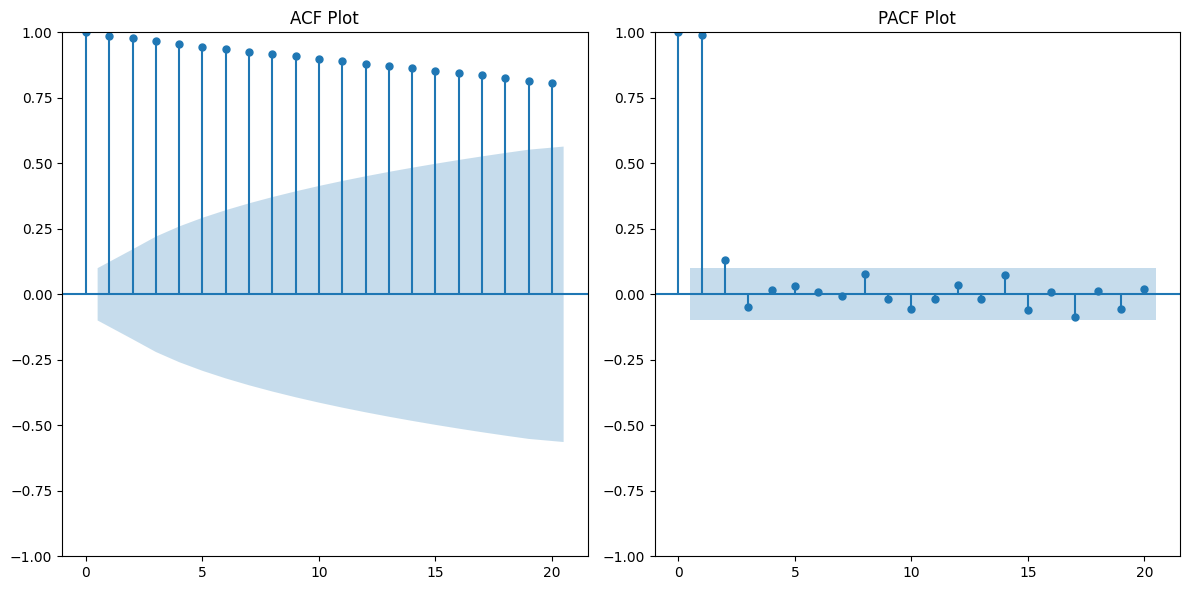

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(close_prices, lags=20, ax=plt.gca())
plt.title("ACF Plot")
plt.subplot(122)
plot_pacf(close_prices, lags=20, ax=plt.gca())
plt.title("PACF Plot")
plt.tight_layout()
plt.show()


In [6]:
from pmdarima import auto_arima

# Auto ARIMA
model = auto_arima(
    close_prices, 
    seasonal=False,        # Set to True if seasonality is expected
    stepwise=True,         # Use a stepwise search to reduce computation
    suppress_warnings=True # Suppress convergence warnings
)

print(model.summary())

# Best parameters
p, d, q = model.order
print(f"Optimal ARIMA order: p={p}, d={d}, q={q}")


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  385
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 601.775
Date:                Sun, 01 Dec 2024   AIC                          -1197.551
Time:                        19:01:58   BIC                          -1185.699
Sample:                             0   HQIC                         -1192.850
                                - 385                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0039      0.002      1.622      0.105      -0.001       0.009
ma.L1         -0.1172      0.045     -2.592      0.010      -0.206      -0.029
sigma2         0.0025   9.77e-05     26.087      0.0

In [7]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Split data into training and validation sets
train_size = int(0.8 * len(close_prices))
train, validation = close_prices[:train_size], close_prices[train_size:]

# Fit ARIMA on training data
model = ARIMA(train, order=(p, d, q))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(validation))
rmse = np.sqrt(mean_squared_error(validation, forecast))
print(f"RMSE: {rmse:.4f}")


RMSE: 0.2806


In [8]:
import itertools

# Define parameter ranges
p = range(0, 4)
d = range(0, 2)
q = range(0, 4)

# Grid search over combinations
parameters = list(itertools.product(p, d, q))
best_aic = float("inf")
best_order = None

for order in parameters:
    try:
        model = ARIMA(close_prices, order=order)
        model_fit = model.fit()
        aic = model_fit.aic
        if aic < best_aic:
            best_aic = aic
            best_order = order
    except:
        continue

print(f"Best ARIMA Order: {best_order} with AIC: {best_aic}")


c:\Users\kh\Desktop\mbb_stock_prediction_analysis\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\kh\Desktop\mbb_stock_prediction_analysis\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\kh\Desktop\mbb_stock_prediction_analysis\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\kh\Desktop\mbb_stock_prediction_analysis\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn

Best ARIMA Order: (1, 1, 0) with AIC: -1196.7198575625707


c:\Users\kh\Desktop\mbb_stock_prediction_analysis\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


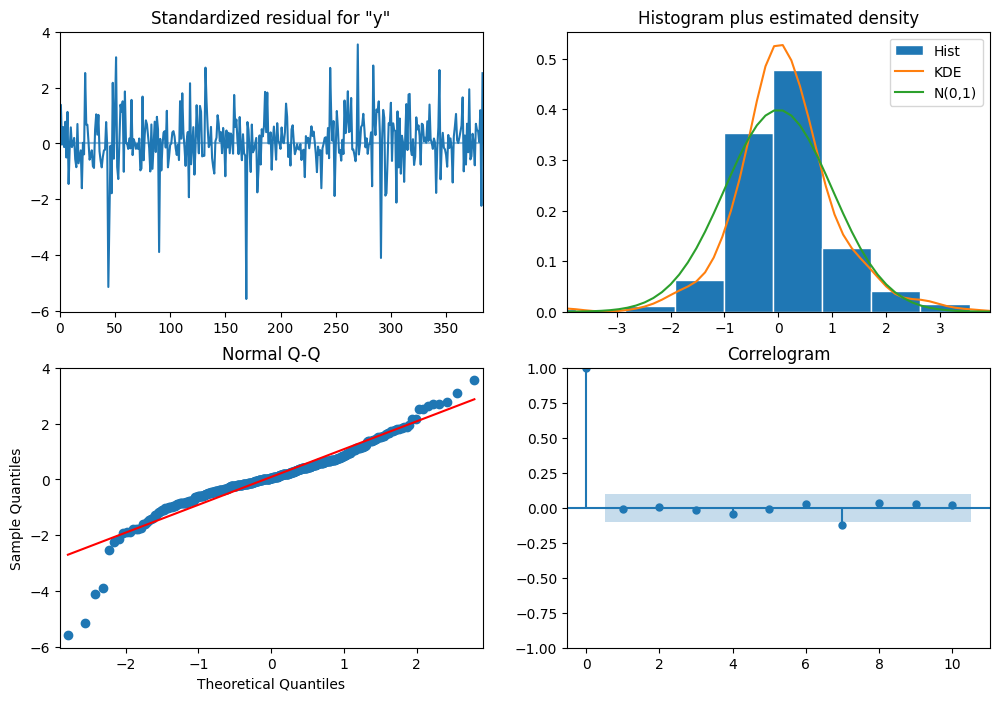

RMSE: 0.2801


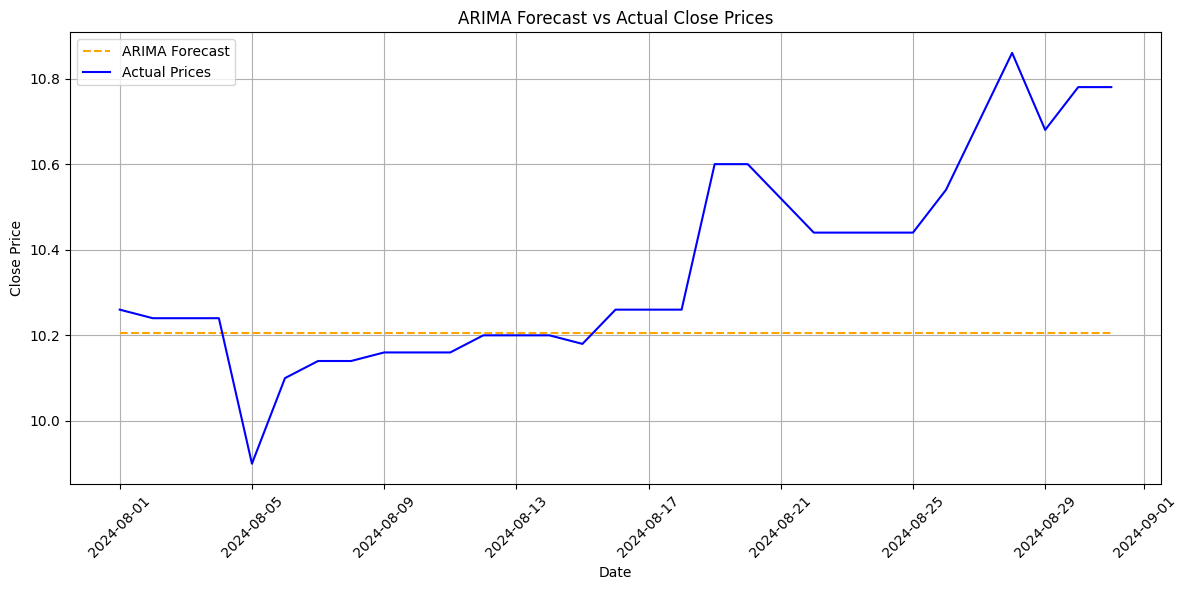

In [10]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load the Close prices (already fetched from Yahoo Finance)
close_prices = data['Close'].dropna().values

# Step 1: Differencing for stationarity
differenced_data = np.diff(close_prices, n=1)  # First-order differencing

# Step 2: ARIMA Model
arima_order = (0, 1, 1)  # From SARIMAX output
model = ARIMA(close_prices, order=arima_order)
model_fit = model.fit(method_kwargs={"maxiter": 1000})

# Step 3: Diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

# Step 4: Forecasting
forecast_horizon = 31
forecast = model_fit.forecast(steps=forecast_horizon)

# Step 5: Evaluation
actual_prices = actual_data['Close'].values
forecast_dates = pd.date_range(start="2024-08-01", periods=forecast_horizon)

# Align lengths
min_length = min(len(actual_prices), len(forecast))
actual_prices = actual_prices[:min_length]
forecast = forecast[:min_length]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_prices, forecast))
print(f"RMSE: {rmse:.4f}")

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates[:min_length], forecast, label="ARIMA Forecast", color="orange", linestyle="--")
plt.plot(forecast_dates[:min_length], actual_prices, label="Actual Prices", color="blue", linestyle="-")
plt.title("ARIMA Forecast vs Actual Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


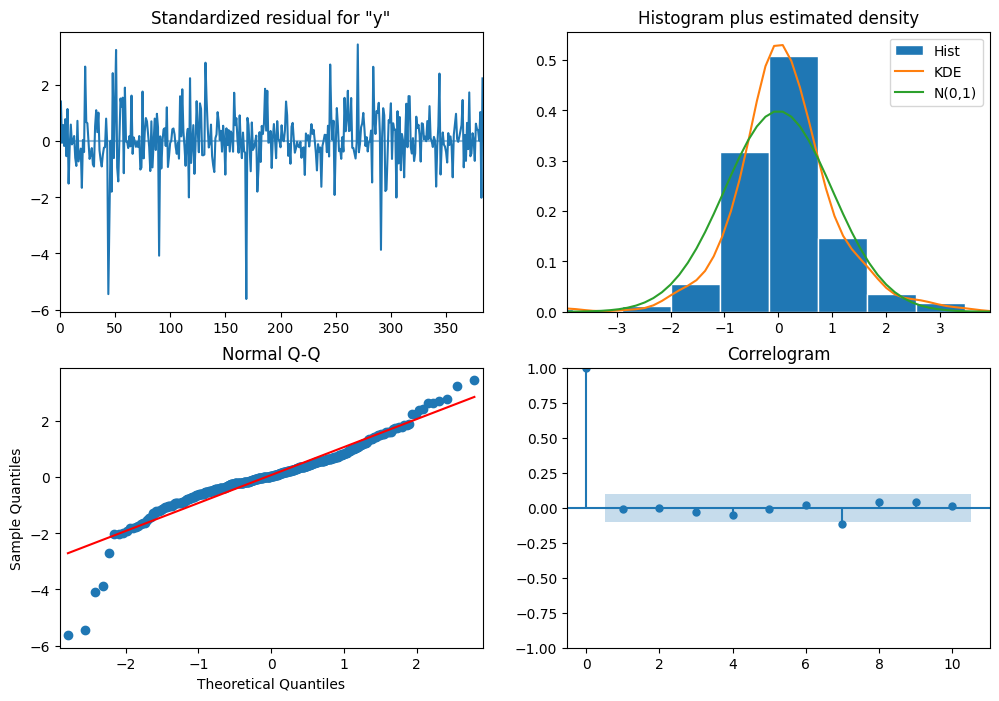

Evaluation Metrics (Refined ARIMA):
Mean Absolute Error (MAE): 0.1991
Mean Squared Error (MSE): 0.0779
Root Mean Squared Error (RMSE): 0.2791
Mean Absolute Percentage Error (MAPE): 1.89%


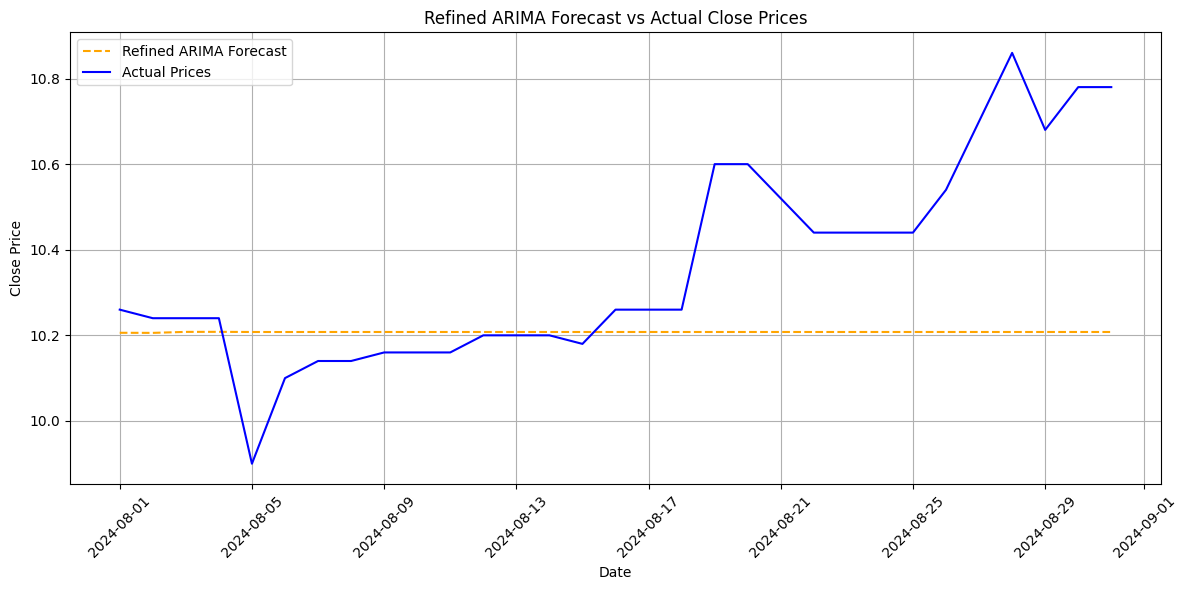

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Preprocess Data
# Log-transform the data to stabilize variance (optional)
log_close_prices = np.log(close_prices)

# Step 2: Define ARIMA Model (Try different orders)
arima_order = (2, 1, 2)  # Refined order based on diagnostics
model = ARIMA(log_close_prices, order=arima_order)

# Step 3: Fit Model
model_fit = model.fit(method_kwargs={"maxiter": 1000})

# Step 4: Diagnostics
model_fit.plot_diagnostics(figsize=(12, 8))
plt.show()

# Step 5: Forecasting
forecast_horizon = 31
forecast_log = model_fit.forecast(steps=forecast_horizon)
forecast = np.exp(forecast_log)  # Reverse log transformation

# Align actual and forecast data lengths
min_length = min(len(actual_prices), len(forecast))
actual_prices = actual_prices[:min_length]
forecast = forecast[:min_length]
forecast_dates = pd.date_range(start="2024-08-01", periods=min_length)

# Step 6: Evaluate Model
mae = mean_absolute_error(actual_prices, forecast)
mse = mean_squared_error(actual_prices, forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_prices - forecast) / (actual_prices + 1e-8))) * 100

print("Evaluation Metrics (Refined ARIMA):")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Step 7: Plot Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, forecast, label="Refined ARIMA Forecast", color="orange", linestyle="--")
plt.plot(forecast_dates, actual_prices, label="Actual Prices", color="blue", linestyle="-")
plt.title("Refined ARIMA Forecast vs Actual Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
c:\Users\kh\Desktop\mbb_stock_prediction_analysis\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kh\Desktop\mbb_stock_prediction_analysis\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kh\Desktop\mbb_stock_prediction_analysis\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\kh\Desktop\mbb_stock_prediction_

Evaluation Metrics (SARIMAX):
Mean Absolute Error (MAE): 0.1996
Mean Squared Error (MSE): 0.0783
Root Mean Squared Error (RMSE): 0.2798
Mean Absolute Percentage Error (MAPE): 1.89%


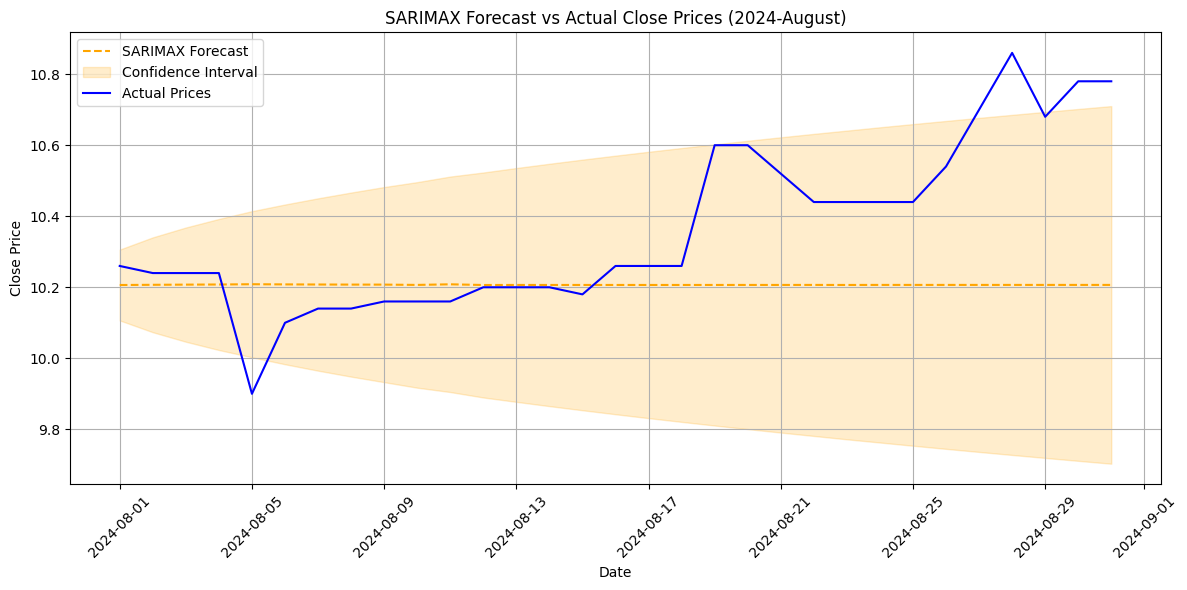

In [13]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Step 1: Fetch historical data
ticker = "1155.KL"
data = yf.download(ticker, start="2023-01-01", end="2024-08-01")
actual_data = yf.download(ticker, start="2024-08-01", end="2024-09-01")

# Extract Close prices and exogenous variables
close_prices = data['Close'].dropna()
exog_data = data[['Volume']]  # Example exogenous variable
exog_data = exog_data.fillna(method='ffill')  # Handle missing values

# Add placeholder exogenous variables for future forecasting
future_exog = np.tile(exog_data.iloc[-1].values, (31, 1))  # Repeat last known exog values for 31 days

# Step 2: Fit SARIMAX Model
sarimax_order = (2, 1, 2)
seasonal_order = (1, 0, 1, 12)

# Fit SARIMAX model
model = SARIMAX(
    close_prices,
    order=sarimax_order,
    seasonal_order=seasonal_order,
    exog=exog_data,
    enforce_stationarity=False,
    enforce_invertibility=False,
)
model_fit = model.fit(disp=False)

# Step 3: Forecast
forecast_horizon = 31
forecast = model_fit.get_forecast(steps=forecast_horizon, exog=future_exog)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Step 4: Align Actual Data with Forecast Dates
forecast_dates = pd.date_range(start="2024-08-01", periods=forecast_horizon)

# Reindex actual data to align with forecast dates
actual_data = actual_data.reindex(forecast_dates, method='ffill')
actual_prices = actual_data['Close'].values
actual_dates = actual_data.index

# Handle remaining length mismatches
if len(actual_prices) != len(forecast_mean):
    print(f"Warning: Length mismatch! Forecast ({len(forecast_mean)}) vs Actual ({len(actual_prices)})")
    min_length = min(len(actual_prices), len(forecast_mean))
    actual_prices = actual_prices[:min_length]
    forecast_mean = forecast_mean[:min_length]
    forecast_dates = forecast_dates[:min_length]

# Step 5: Calculate Evaluation Metrics
mae = mean_absolute_error(actual_prices, forecast_mean)
mse = mean_squared_error(actual_prices, forecast_mean)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((actual_prices - forecast_mean) / (actual_prices + 1e-8))) * 100

print("Evaluation Metrics (SARIMAX):")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Step 6: Plot Forecast vs Actual
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, forecast_mean, label="SARIMAX Forecast", color="orange", linestyle="--")
plt.fill_between(
    forecast_dates,
    forecast_conf_int.iloc[:, 0],
    forecast_conf_int.iloc[:, 1],
    color="orange",
    alpha=0.2,
    label="Confidence Interval",
)
plt.plot(forecast_dates, actual_prices, label="Actual Prices", color="blue", linestyle="-")
plt.title("SARIMAX Forecast vs Actual Close Prices (2024-August)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
